In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

# Load telemetry data
df = pd.read_csv('segments.csv', parse_dates=['timestamp'])
df = df.sort_values(by=['channel', 'timestamp']).reset_index(drop=True)

# Sneak peek into the dataset
channel = df['channel'].unique()[0]
df_channel = df[df['channel'] == channel].reset_index(drop=True)
print(f"✅ Loaded {len(df_channel)} rows from channel: {channel}")

# Dataset
print(df.head())

✅ Loaded 66819 rows from channel: CADC0872
    channel                 timestamp     value    label  sampling  anomaly  \
0  CADC0872 2022-01-04 20:00:50+00:00 -0.000011  anomaly         5        0   
1  CADC0872 2022-01-04 20:00:55+00:00 -0.000011  anomaly         5        0   
2  CADC0872 2022-01-04 20:01:00+00:00 -0.000006  anomaly         5        0   
3  CADC0872 2022-01-04 20:01:05+00:00  0.000002  anomaly         5        0   
4  CADC0872 2022-01-04 20:01:10+00:00  0.000011  anomaly         5        0   

   segment  train  
0     1818      1  
1     1818      1  
2     1818      1  
3     1818      1  
4     1818      1  


In [7]:
# PREPROCESSING & WINDOW CREATION
window_size = 96  # sliding window size

# Normalize the signal values
scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(df_channel['value'].values.reshape(-1, 1)).flatten()

# Create overlapping windows
def create_windows(data, w_size):
    return np.array([data[i:i+w_size] for i in range(len(data)-w_size+1)])

# Split training (normal) data for AE & IF training
normal_data = df_channel[df_channel['anomaly'] == 0]
X_train_scaled = scaler.transform(normal_data['value'].values.reshape(-1,1)).flatten()
X_train_windows = create_windows(X_train_scaled, window_size)
X_train_windows = X_train_windows.reshape(-1, window_size, 1)

print(f" Created {X_train_windows.shape[0]} training windows")


✅ Created 42358 training windows


In [8]:
# ML MODEL TRAINING

# Build Autoencoder
def build_autoencoder(input_shape, latent_dim=16):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 7, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    shape_before_flatten = tf.keras.backend.int_shape(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim)(x)
    x = layers.Dense(np.prod(shape_before_flatten[1:]), activation='relu')(latent)
    x = layers.Reshape(shape_before_flatten[1:])(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(32, 7, activation='relu', padding='same')(x)
    outputs = layers.Conv1D(1, 1, activation='linear', padding='same')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Train Autoencoder
autoencoder = build_autoencoder((window_size, 1))
autoencoder.fit(X_train_windows, X_train_windows, epochs=10, batch_size=32, verbose=1)

# Isolation Forest
X_train_flat = X_train_windows.reshape(X_train_windows.shape[0], -1)
iforest = IsolationForest(contamination=0.05, random_state=42)
iforest.fit(X_train_flat)
print(" Autoencoder & Isolation Forest trained")


Epoch 1/10

1324/1324 [==============================] - 17s 11ms/step - loss: 0.0302
Epoch 2/10
1324/1324 [==============================] - 13s 10ms/step - loss: 0.0052
Epoch 3/10
1324/1324 [==============================] - 14s 10ms/step - loss: 0.0037
Epoch 4/10
1324/1324 [==============================] - 17s 13ms/step - loss: 0.0034
Epoch 5/10
1324/1324 [==============================] - 16s 12ms/step - loss: 0.0029
Epoch 6/10
1324/1324 [==============================] - 19s 14ms/step - loss: 0.0027
Epoch 7/10
1324/1324 [==============================] - 20s 15ms/step - loss: 0.0025
Epoch 8/10
1324/1324 [==============================] - 14s 10ms/step - loss: 0.0024
Epoch 9/10
1324/1324 [==============================] - 12s 9ms/step - loss: 0.0023
Epoch 10/10
1324/1324 [==============================] - 17s 13ms/step - loss: 0.0020
✅ Autoencoder & Isolation Forest trained


In [9]:
# REAL-TIME ANOMALY DETECTION (Sliding window simulation)

X_test_windows = create_windows(X_scaled_all, window_size).reshape(-1, window_size, 1)
reconstruction_errors = []
isolation_scores = []

for window in X_test_windows:
    # AE Reconstruction Error
    recon = autoencoder.predict(window[np.newaxis, :, :], verbose=0)
    error = np.mean((recon - window[np.newaxis, :, :])**2)
    reconstruction_errors.append(error)
    
    # IF score (negative outlier score, invert it)
    score = -iforest.decision_function(window.reshape(1, -1))[0]
    isolation_scores.append(score)

# Ensemble score (weighted)
ensemble_scores = 0.5 * np.array(reconstruction_errors) + 0.5 * np.array(isolation_scores)
print(" Ensemble anomaly scores computed")


✅ Ensemble anomaly scores computed


In [10]:
# THRESHOLDING & PREDICTION

def adaptive_threshold(scores, base_thresh=None, window=20):
    smooth = np.convolve(scores, np.ones(window)/window, mode='same')
    if base_thresh is None:
        base_thresh = np.mean(smooth) + 0.5 * np.std(smooth)
    return (smooth > base_thresh).astype(int)

preds = adaptive_threshold(ensemble_scores)
print(" Adaptive thresholding applied")


✅ Adaptive thresholding applied


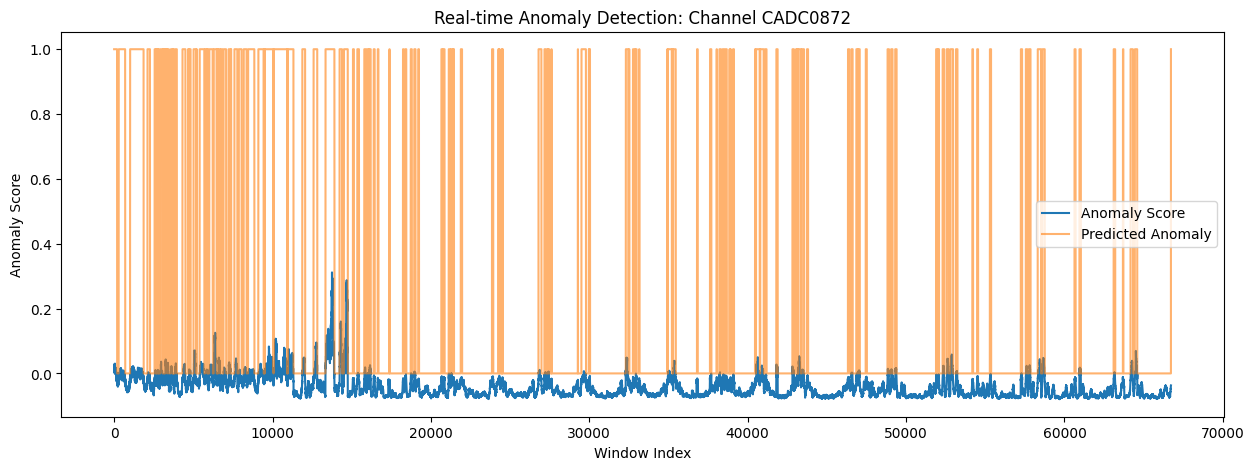

In [11]:
# RESULTS & VISUALIZATION

plt.figure(figsize=(15,5))
plt.plot(ensemble_scores, label='Anomaly Score')
plt.plot(preds, label='Predicted Anomaly', alpha=0.6)
plt.title(f"Real-time Anomaly Detection: Channel {channel}")
plt.xlabel('Window Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()


In [12]:
# PERFORMANCE ANALYSIS

# Ground truth label for each window: majority vote
true_labels = []
for i in range(len(df_channel) - window_size + 1):
    window = df_channel['anomaly'].iloc[i:i+window_size]
    true_labels.append(int(window.mode()[0]))

print("Classification Report:")
print(classification_report(true_labels, preds))

print("Confusion Matrix:")
print(confusion_matrix(true_labels, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.76      0.70     42793
           1       0.38      0.26      0.31     23931

    accuracy                           0.58     66724
   macro avg       0.52      0.51      0.51     66724
weighted avg       0.55      0.58      0.56     66724

Confusion Matrix:
[[32620 10173]
 [17624  6307]]


In [22]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(true_labels, ensemble_scores)
print(f"ROC AUC Score: {auc:.4f}")


ROC AUC Score: 0.4875


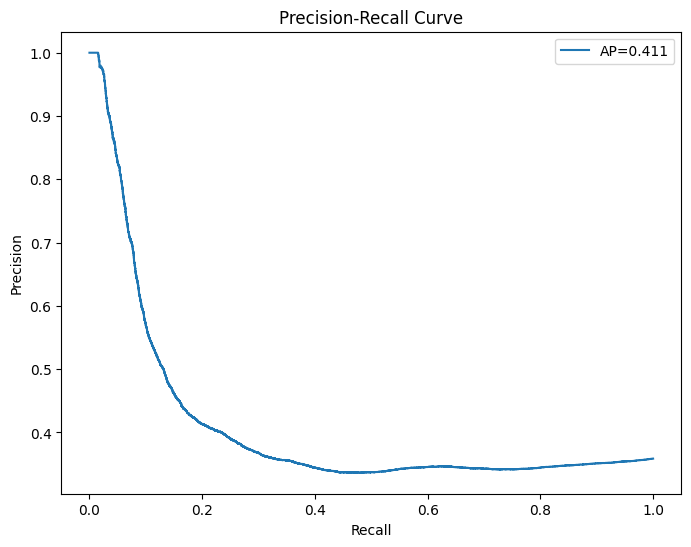

In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(true_labels, ensemble_scores)
ap = average_precision_score(true_labels, ensemble_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP={ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


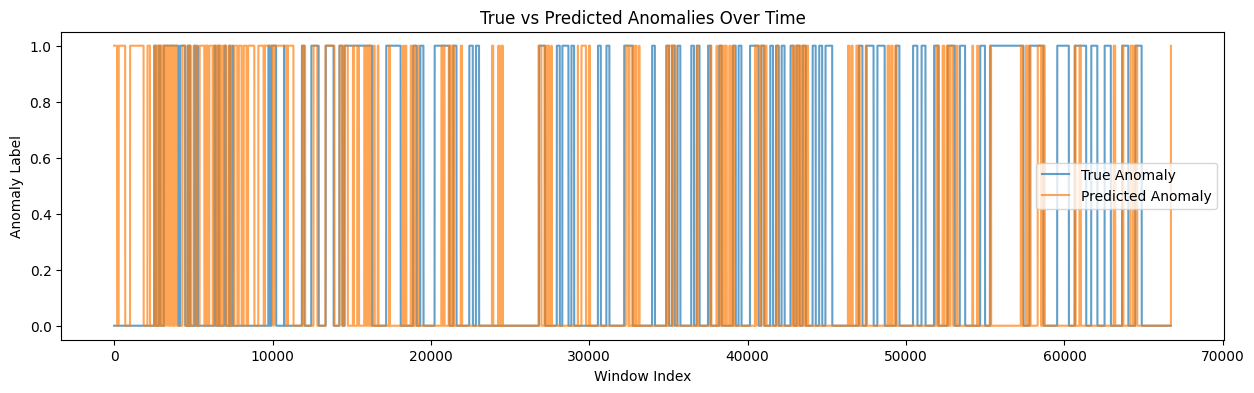

In [24]:
plt.figure(figsize=(15, 4))
plt.plot(true_labels, label='True Anomaly', alpha=0.7)
plt.plot(preds, label='Predicted Anomaly', alpha=0.7)
plt.title('True vs Predicted Anomalies Over Time')
plt.xlabel('Window Index')
plt.ylabel('Anomaly Label')
plt.legend()
plt.show()


In [25]:
tn, fp, fn, tp = confusion_matrix(true_labels, preds).ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
print(f"False Positive Rate: {fpr:.4f}")
print(f"False Negative Rate: {fnr:.4f}")


False Positive Rate: 0.2377
False Negative Rate: 0.7365


In [30]:
def reduce_false_positives(predictions, min_anomaly_length=):
    
    smoothed_preds = predictions.copy()
    start = None
    for i in range(len(predictions)):
        if predictions[i] == 1 and start is None:
            start = i
        elif predictions[i] == 0 and start is not None:
            length = i - start
            if length < min_anomaly_length:
                smoothed_preds[start:i] = 0  # remove short anomaly burst
            start = None
    # Handle anomaly at end
    if start is not None:
        length = len(predictions) - start
        if length < min_anomaly_length:
            smoothed_preds[start:] = 0

    return smoothed_preds

# Apply false positive reduction
preds_smooth = reduce_false_positives(preds, min_anomaly_length=3)
print("False positives reduced by smoothing")

# Then use preds_smooth for evaluation and plotting instead of preds


✅ False positives reduced by smoothing


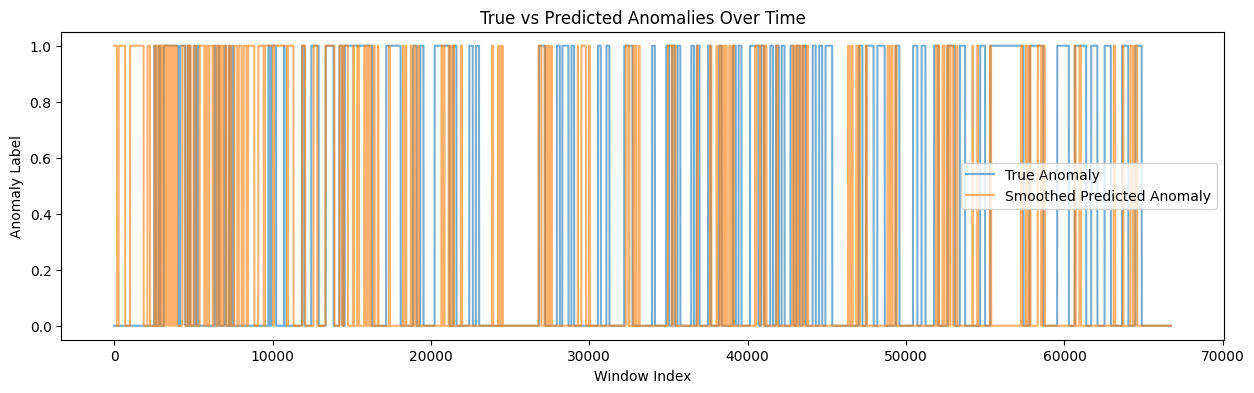

In [31]:
plt.figure(figsize=(15, 4))
plt.plot(true_labels, label='True Anomaly', alpha=0.6)
plt.plot(preds_smooth, label='Smoothed Predicted Anomaly', alpha=0.6)
plt.title('True vs Predicted Anomalies Over Time')
plt.xlabel('Window Index')
plt.ylabel('Anomaly Label')
plt.legend()
plt.show()


In [32]:
print(classification_report(true_labels, preds_smooth))
print(confusion_matrix(true_labels, preds_smooth))

              precision    recall  f1-score   support

           0       0.65      0.76      0.70     42793
           1       0.38      0.26      0.31     23931

    accuracy                           0.58     66724
   macro avg       0.52      0.51      0.51     66724
weighted avg       0.55      0.58      0.56     66724

[[32624 10169]
 [17626  6305]]


In [33]:
tn, fp, fn, tp = confusion_matrix(true_labels, preds_smooth).ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
print(f"False Positive Rate: {fpr:.4f}")
print(f"False Negative Rate: {fnr:.4f}")

False Positive Rate: 0.2376
False Negative Rate: 0.7365
